# Supervised Learning Hands On

## Download data of today's example:


**Gene expression data for cancer samples from the TCGA database**: using the xenaPython module 

In [1]:
import numpy as np
import pandas as pd
import xenaPython as xena
import re

def trasform_codes(code_list,code_keys): 
  keys=re.split(r'\t', code_keys)  
  not_nan_indices = [i for i, x in enumerate(code_list) if x != "NaN"];   
  for i in not_nan_indices :
      code_list[i]=keys[code_list[i]]
  return code_list

def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 

hub = "https://tcga.xenahubs.net"
all_datasets=np.array(xena.all_datasets(hub))

target_data_type='HiSeqV2_PANCAN'
#RSEM in log2(x+1), pan-cancer normalized, https://xenabrowser.net/datapages/?dataset=TCGA.BLCA.sampleMap%2FHiSeqV2_PANCAN&host=https%3A%2F%2Ftcga.xenahubs.net&removeHub=https%3A%2F%2Fxena.treehouse.gi.ucsc.edu%3A443 
clinical_data_type='clinicalMatrix'
clinical_fields=[ 'clinical_stage', 'days_to_birth', 'gender', 'vital_status', 'days_to_last_followup']
clinical_fields_alt=[ 'pathologic_stage', 'days_to_birth', 'gender', 'vital_status', 'days_to_last_followup']
clinical_fields_legends=['stage', 'age', 'gender', 'status', 'time']                      
print("Will read the following clinical information: {}".format(clinical_fields))

samplesToSkip=["COADREAD","LUNG"]

minimal_number_of_samples=200

my_gene_universe=0
gene_names=[]
gene_expression_matrix=[]
clinical_matrix=[]
my_cancer_types=[]
my_cancer_types_clinical=[]

#check how many datasets we can use
#save them in 'my_cancer_types'

for entry in all_datasets:
  if entry['name'][-len(target_data_type):]==target_data_type:   
    dataset=entry['name']
    datasetCancerType=dataset[:dataset.find(target_data_type)-1]; datasetCancerType=datasetCancerType[5:-10]
    my_cancer_types.append(datasetCancerType)
    if my_gene_universe==0:
        my_gene_universe=xena.dataset_field_n (hub, dataset)
    else:
        if (my_gene_universe!=xena.dataset_field_n (hub, dataset)):
            print("ERROR! DIFFERENT GENE NUMBER!")
    gene_names=xena.dataset_field (hub, dataset)
    samples=xena.dataset_samples(hub, dataset, None)
    
    if (len(samples)!=len(np.unique(np.array(samples)))):
        print("WARNING: duplicate sample names for {}".format(datasetCancerType))
    
    gene_exp_list=xena.dataset_fetch(hub, dataset, samples, gene_names) 
    gene_exp_list=np.transpose(np.array(gene_exp_list))    
    gene_exp_list=pd.DataFrame(gene_exp_list)
    gene_exp_list.columns = gene_names
    gene_exp_list=gene_exp_list.drop(columns=['psiTPTE22', 'sampleID', 'tAKR'])

    if (len(samples)!=gene_exp_list.shape[0]):
        print("WARNING: duplicate sample information for {}".format(datasetCancerType))
     
    gene_exp_list.index=samples 
    if len(gene_expression_matrix)==0:
        gene_expression_matrix=gene_exp_list
    else:
        gene_expression_matrix=pd.concat([gene_expression_matrix,gene_exp_list], axis=0)

  elif entry['name'][-len(clinical_data_type):]==clinical_data_type:  
    dataset=entry['name']
    datasetCancerTypeClin=dataset[5:dataset.find('sampleMap')-1]
    samples=xena.dataset_samples(hub, dataset, None); 
        
    if (datasetCancerTypeClin in samplesToSkip):
        print("Will skip cancer type {}".format (datasetCancerTypeClin))
        continue
    
    if len(samples) < minimal_number_of_samples :
        print("WARNING: {} has fewer than {} samples".format(datasetCancerTypeClin,minimal_number_of_samples))
        print("Will skip this cancer type")
        continue
       
    my_code_list=xena.field_codes(hub, dataset, clinical_fields)
    my_codes_clinical=xena.dataset_fetch(hub, dataset, samples, clinical_fields)
    
    alt=False
    if len(clinical_fields)!=len(my_code_list) :
        print("WARNING: will use pathologic_stage instead of clinical_stage for {}".format(datasetCancerTypeClin))
        my_code_list=xena.field_codes(hub, dataset, clinical_fields_alt)
        my_codes_clinical=xena.dataset_fetch(hub, dataset, samples, clinical_fields_alt)
        alt=True
        if len(clinical_fields_alt)!=len(my_code_list) :
            print("WARNING: not all clinical fields available for samples from {}".format(datasetCancerTypeClin))
            print("Will skip this cancer type")
            continue
    my_cancer_types_clinical.append(datasetCancerTypeClin)
    my_clinical_features_local= []
    for i in range(len(my_code_list)) :
        my_field=my_code_list[i]['name']
        if alt :
            j=clinical_fields_alt.index(my_field)            
        else :
            j=clinical_fields.index(my_field)
        if(my_code_list[i]['code']!=None) :
            my_codes_clinical[j]=trasform_codes(my_codes_clinical[j],my_code_list[i]['code'])
        my_clinical_features_local.append(my_codes_clinical[i])
    my_clinical_features_local=np.transpose(np.array(my_clinical_features_local))
    my_clinical_features_local=pd.DataFrame(my_clinical_features_local)
    my_clinical_features_local.columns = clinical_fields_legends
    my_clinical_features_local.index=samples 
    my_clinical_features_local['type']=datasetCancerTypeClin
    if len(clinical_matrix)==0:
        clinical_matrix=my_clinical_features_local
    else:
        clinical_matrix=pd.concat([clinical_matrix,my_clinical_features_local], axis=0)
        
print("Will use {} datasets".format(len(my_cancer_types_clinical)))
print(my_cancer_types_clinical)

#remove duplicated patients (completely) from the expression matrix
mylistpatientswithexpression=gene_expression_matrix.index.values.tolist()
myDuplicateValues=[]
for elem in mylistpatientswithexpression:
    if mylistpatientswithexpression.count(elem) > 1:
        myDuplicateValues.append(elem)
print("WARNING: will exclude {} values as duplicates". format(len(myDuplicateValues)))
gene_expression_matrix=gene_expression_matrix.drop(myDuplicateValues)

full_df=gene_expression_matrix.merge(clinical_matrix, left_index=True, right_index=True)
print("Will use {} patients".format(full_df.shape[0]))


C:\ProgramData\Anaconda3\lib\site-packages\xenaPython\__init__.py:110: FutureWarning: Possible nested set at position 7
  re.sub(r"^[^[]+[[]([^]]*)[]].*$", r"\1", query, flags=re.DOTALL))


Will read the following clinical information: ['clinical_stage', 'days_to_birth', 'gender', 'vital_status', 'days_to_last_followup']
Will skip this cancer type
Will skip this cancer type
Will skip this cancer type
Will skip this cancer type
Will skip this cancer type
Will skip this cancer type
Will skip cancer type COADREAD
Will skip cancer type LUNG
Will skip this cancer type
Will skip this cancer type
Will skip this cancer type
Will skip this cancer type
Will skip this cancer type
Will skip this cancer type
Will skip this cancer type
Will skip this cancer type
Will skip this cancer type
Will skip this cancer type
Will skip this cancer type
Will skip this cancer type
Will skip this cancer type
Will use 16 datasets
['OV', 'KIRC', 'COAD', 'LUSC', 'LUAD', 'KIRP', 'CESC', 'SKCM', 'BLCA', 'BRCA', 'UCEC', 'LIHC', 'THCA', 'HNSC', 'ESCA', 'STAD']
Will use 6071 patients


**Check the characteristics of the input data set and do some data cleaning:**

In [2]:
import pandas_profiling #v2.4: conda install -c conda-forge/label/cf202003 pandas-profiling 

profile = pandas_profiling.ProfileReport(full_df[['stage', 'age','gender', 'status', 'time','type']], title='Pandas Profiling Report', html={'style':{'full_width':True}},minimal=True)
profile.to_notebook_iframe()

#exlude NA cells:
df_noNA=full_df

df_noNA = df_noNA[(df_noNA['stage']!='[Discrepancy]') &(df_noNA['status']!='[Discrepancy]') & (df_noNA['time']!='[Discrepancy]') ]

for colname in ['stage', 'age', 'gender', 'status', 'time']:
    if (sum(df_noNA[colname]=='NaN')>0):
        df_noNA = df_noNA[(df_noNA[colname]!='NaN')] 
#remove Stage X:         
df_noNA = df_noNA[(df_noNA['stage']!='Stage X')] 

print("Number of patients without NA: {}".format(df_noNA.shape[0]))

df_noNA['age']=[int(i) for i in df_noNA['age']]  
df_noNA['time']=[int(i) for i in df_noNA['time']]  
profile = pandas_profiling.ProfileReport(df_noNA[['stage', 'age', 'gender', 'status', 'time','type']], title='Pandas Profiling Report', html={'style':{'full_width':True}},minimal=True)
profile.to_notebook_iframe()

Number of patients without NA: 4540


## Classification task

**k Nearest Neighbors, Logistic regression, Support Vector Machines, Naive Bayes, RandomForest, AdaBoost, Gradient Tree Boosting (gradient boosting machine), multi-layer perceptron (MLP)**

**Create X and y for the classification task**:

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set()


X1 = df_noNA.drop(columns=['stage', 'age', 'gender', 'status', 'time','type'])
X2=df_noNA.drop(columns=['status', 'time','type']) #can exlcude 'gender', as it is breat cancer
X2=X2[(df_noNA['type']=="BRCA")]

y1 = df_noNA['type']
y2 = df_noNA['status'][(df_noNA['type']=="BRCA")]

print("For set 1 will use {} patients".format(len(y1)))
print("For set 2 will use {} patients".format(len(y2)))
   
num_cancer_type=len(set(y1))
current_palette = sns.color_palette("colorblind")+sns.color_palette("dark")+sns.color_palette("deep")
current_palette=current_palette[0:num_cancer_type]
#visualize the palette if needed:
#sns.palplot(current_palette)
colors1 = current_palette
colors2=current_palette[1:3]

#replace string values by float in X
dictionary = {'Stage I': 1.5, 'Stage IA': 1.4, 'Stage IB': 1.6, 'Stage II': 2.5, 'Stage IIA': 2.4, 'Stage IIB': 2.6,
              'Stage III': 3.5, 'Stage IIIA': 3.4, 'Stage IIIB': 3.6, 'Stage IIIC': 3.8, 'Stage IV': 4.5}
X2=X2.replace({'stage': dictionary})
dictionary = {'MALE': 0, 'FEMALE': 1}
X2=X2.replace({'gender': dictionary})

X2_no_clinical=X2.drop(columns=['stage', 'age', 'gender'])

For set 1 will use 4540 patients
For set 2 will use 1042 patients


### Apply different clustering techniques and calculate clustering accuracy

In [4]:
import time
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score

#will be splitting the dataset into train:test as 7:3
test_size=0.3

def printAndSaveInfo(name, my_time, accuracy_score, my_F1, scoreDict, timeDict, F1Dict, title):
    scoreDict[name] = accuracy_score
    timeDict[name] = my_time
    F1Dict[name]= my_F1
    print("---{}: {} seconds ---".format (name, my_time))
    print('{}, {} accuracy score: {}, F1-score: {}'.format(title, name, accuracy_score, my_F1) )   

def getF1(y_test, y_predicted):
    if (len(np.unique(y_test))>2):
         return f1_score(y_test, y_predicted, average='micro')
    else:
         return f1_score(y_test, y_predicted, pos_label='DECEASED')      
  

scores=[]
F1=[]
times=[]

for X, y, colors, title in [(X1, y1, colors1, "TCGA tumor type classification task"), 
                            (X2, y2, colors2, "breast cancer relapse prediction task, with clinical info"),
                            (X2_no_clinical, y2, colors2, "breast cancer relapse prediction task, w/o clinical info")]:
    # Split the dataset in two for training and testing:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)
    scoreDict={}
    timeDict={}
    F1Dict={}
        
    # run k-NN:
    n_neighbors=15
    start_time = time.time()
    clf = KNeighborsClassifier(n_neighbors, weights='distance').fit(X_train, y_train) #default 'uniform'
    printAndSaveInfo("kNN", time.time() - start_time, clf.score(X_test, y_test), 
                     getF1(y_test, clf.predict(X_test)), scoreDict, timeDict, F1Dict, title)
    
    # run logistic regression:
    start_time = time.time()
    clf = LogisticRegression(solver='sag', max_iter=400, random_state=42).fit(X_train, y_train)
    printAndSaveInfo("Log. reg. (sag)", time.time() - start_time, clf.score(X_test, y_test), 
                     getF1(y_test, clf.predict(X_test)), scoreDict, timeDict, F1Dict, title)

    # logistic regression with L1+L2 penalty:
    start_time = time.time()
    clf = LogisticRegression(solver='saga', max_iter=400, penalty="elasticnet", l1_ratio=0.5, random_state=42).fit(X_train, y_train)
    printAndSaveInfo("Log. reg. (elasticnet)", time.time() - start_time, clf.score(X_test, y_test), 
                     getF1(y_test, clf.predict(X_test)), scoreDict, timeDict, F1Dict, title)

    # run Support Vector Machines:
    start_time = time.time()
    clf = svm.SVC(kernel='linear', C=1,random_state=42).fit(X_train, y_train)
    printAndSaveInfo("SVM", time.time() - start_time, clf.score(X_test, y_test), 
                     getF1(y_test, clf.predict(X_test)), scoreDict, timeDict, F1Dict, title)

    #Naive Bayes (Gaussian):
    start_time = time.time()
    clf = GaussianNB().fit(X_train, y_train)
    printAndSaveInfo("GaussianNB", time.time() - start_time, clf.score(X_test, y_test), 
                     getF1(y_test, clf.predict(X_test)), scoreDict, timeDict, F1Dict, title)

    #RandomForest:
    start_time = time.time()
    clf = RandomForestClassifier(random_state=42).fit(X_train, y_train)
    printAndSaveInfo("RandomForest", time.time() - start_time, clf.score(X_test, y_test), 
                     getF1(y_test, clf.predict(X_test)), scoreDict, timeDict, F1Dict, title)

    #AdaBoost:
    start_time = time.time()
    clf = AdaBoostClassifier(random_state=42).fit(X_train, y_train)
    printAndSaveInfo("AdaBoost", time.time() - start_time, clf.score(X_test, y_test), 
                     getF1(y_test, clf.predict(X_test)), scoreDict, timeDict, F1Dict, title)
    
    #Gradient Tree Boosting (gradient boosting machine):
    start_time = time.time()
    clf = GradientBoostingClassifier(random_state=42).fit(X_train, y_train)
    printAndSaveInfo("GBM", time.time() - start_time, clf.score(X_test, y_test), 
                     getF1(y_test, clf.predict(X_test)), scoreDict, timeDict, F1Dict, title)
    
    #multi-layer perceptron (MLP):
    start_time = time.time()
    clf = MLPClassifier(random_state=42,solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2)).fit(X_train, y_train)
    printAndSaveInfo("MLP", time.time() - start_time, clf.score(X_test, y_test), 
                     getF1(y_test, clf.predict(X_test)), scoreDict, timeDict, F1Dict, title)

    scores.append(scoreDict)
    times.append(timeDict)
    F1.append(F1Dict)

---kNN: 16.506860971450806 seconds ---
TCGA tumor type classification task, kNN accuracy score: 0.9544787077826725, F1-score: 0.9544787077826725


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


---Log. reg. (sag): 1566.5494797229767 seconds ---
TCGA tumor type classification task, Log. reg. (sag) accuracy score: 0.9838472834067548, F1-score: 0.9838472834067548


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


---Log. reg. (elasticnet): 4571.920627355576 seconds ---
TCGA tumor type classification task, Log. reg. (elasticnet) accuracy score: 0.9860499265785609, F1-score: 0.9860499265785609
---SVM: 54.78099250793457 seconds ---
TCGA tumor type classification task, SVM accuracy score: 0.9845814977973568, F1-score: 0.9845814977973568
---GaussianNB: 2.0508627891540527 seconds ---
TCGA tumor type classification task, GaussianNB accuracy score: 0.7716593245227606, F1-score: 0.7716593245227605
---RandomForest: 25.51479935646057 seconds ---
TCGA tumor type classification task, RandomForest accuracy score: 0.9750367107195301, F1-score: 0.9750367107195301
---AdaBoost: 369.91278195381165 seconds ---
TCGA tumor type classification task, AdaBoost accuracy score: 0.4243759177679883, F1-score: 0.4243759177679883
---GBM: 13383.578814983368 seconds ---
TCGA tumor type classification task, GBM accuracy score: 0.9662261380323054, F1-score: 0.9662261380323054


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


---MLP: 31.180617809295654 seconds ---
TCGA tumor type classification task, MLP accuracy score: 0.6196769456681351, F1-score: 0.6196769456681351
---kNN: 2.452266216278076 seconds ---
breast cancer relapse prediction task, with clinical info, kNN accuracy score: 0.9456869009584664, F1-score: 0.0


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


---Log. reg. (sag): 54.12104153633118 seconds ---
breast cancer relapse prediction task, with clinical info, Log. reg. (sag) accuracy score: 0.9456869009584664, F1-score: 0.0


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


---Log. reg. (elasticnet): 134.90914607048035 seconds ---
breast cancer relapse prediction task, with clinical info, Log. reg. (elasticnet) accuracy score: 0.9456869009584664, F1-score: 0.0
---SVM: 9.64436650276184 seconds ---
breast cancer relapse prediction task, with clinical info, SVM accuracy score: 0.9424920127795527, F1-score: 0.0
---GaussianNB: 0.4914722442626953 seconds ---
breast cancer relapse prediction task, with clinical info, GaussianNB accuracy score: 0.7252396166134185, F1-score: 0.13999999999999999
---RandomForest: 8.25772762298584 seconds ---
breast cancer relapse prediction task, with clinical info, RandomForest accuracy score: 0.9456869009584664, F1-score: 0.0
---AdaBoost: 63.66973376274109 seconds ---
breast cancer relapse prediction task, with clinical info, AdaBoost accuracy score: 0.9361022364217252, F1-score: 0.0
---GBM: 306.1972699165344 seconds ---
breast cancer relapse prediction task, with clinical info, GBM accuracy score: 0.9137380191693291, F1-score: 0.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


---Log. reg. (sag): 55.026920318603516 seconds ---
breast cancer relapse prediction task, w/o clinical info, Log. reg. (sag) accuracy score: 0.9424920127795527, F1-score: 0.0


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


---Log. reg. (elasticnet): 140.0591094493866 seconds ---
breast cancer relapse prediction task, w/o clinical info, Log. reg. (elasticnet) accuracy score: 0.9424920127795527, F1-score: 0.0
---SVM: 6.177269220352173 seconds ---
breast cancer relapse prediction task, w/o clinical info, SVM accuracy score: 0.9424920127795527, F1-score: 0.0
---GaussianNB: 0.42290711402893066 seconds ---
breast cancer relapse prediction task, w/o clinical info, GaussianNB accuracy score: 0.939297124600639, F1-score: 0.0
---RandomForest: 8.235586881637573 seconds ---
breast cancer relapse prediction task, w/o clinical info, RandomForest accuracy score: 0.9456869009584664, F1-score: 0.0
---AdaBoost: 63.601094007492065 seconds ---
breast cancer relapse prediction task, w/o clinical info, AdaBoost accuracy score: 0.9361022364217252, F1-score: 0.0
---GBM: 306.6362838745117 seconds ---
breast cancer relapse prediction task, w/o clinical info, GBM accuracy score: 0.9361022364217252, F1-score: 0.0
---MLP: 3.08878016

### Visualize the output
**Find the best solution: Check execution time and accuracy of the methods tested**

Time:
                                  kNN  Log. reg. (sag)  \
Cancer type classification  16.506861      1566.549480   
Prog. pred. with clin.       2.452266        54.121042   
Prog. pred. w/o clin.        2.139492        55.026920   

                            Log. reg. (elasticnet)        SVM  GaussianNB  \
Cancer type classification             4571.920627  54.780993    2.050863   
Prog. pred. with clin.                  134.909146   9.644367    0.491472   
Prog. pred. w/o clin.                   140.059109   6.177269    0.422907   

                            RandomForest    AdaBoost           GBM        MLP  
Cancer type classification     25.514799  369.912782  13383.578815  31.180618  
Prog. pred. with clin.          8.257728   63.669734    306.197270   0.418753  
Prog. pred. w/o clin.           8.235587   63.601094    306.636284   3.088780  
Accuracy scores:
                                 kNN  Log. reg. (sag)  Log. reg. (elasticnet)  \
Cancer type classification  0.9544

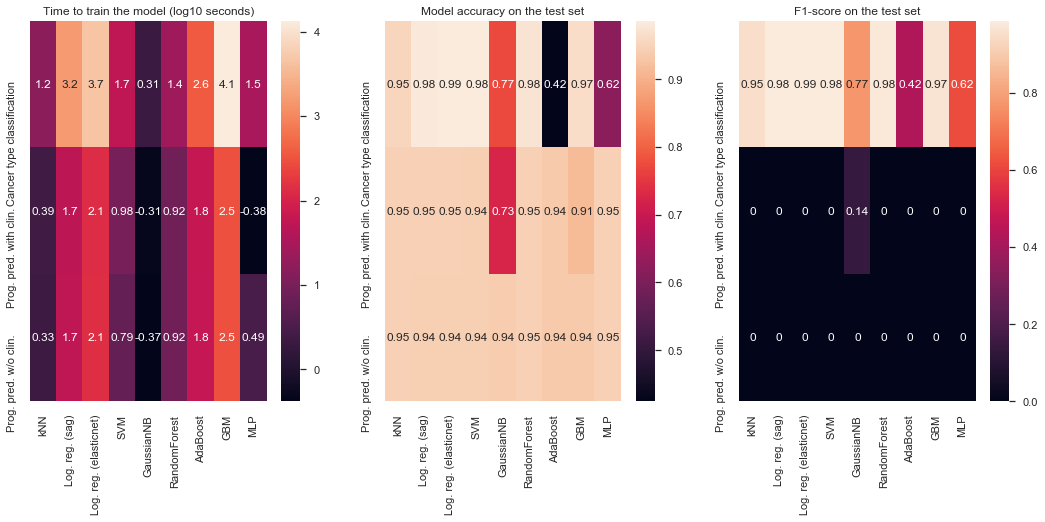

In [6]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

time_df=pd.DataFrame(times)
score_df=pd.DataFrame(scores)
F1_df=pd.DataFrame(F1)

time_df.rename(index={0:'Cancer type classification',1:'Prog. pred. with clin.',2:'Prog. pred. w/o clin.'}, 
                 inplace=True)
score_df.rename(index={0:'Cancer type classification',1:'Prog. pred. with clin.',2:'Prog. pred. w/o clin.'}, 
                 inplace=True)
F1_df.rename(index={0:'Cancer type classification',1:'Prog. pred. with clin.',2:'Prog. pred. w/o clin.'}, 
                 inplace=True)
print("Time:")
print(time_df)
print("Accuracy scores:")
print(score_df)
print("F1-scores:")
print(F1_df)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(18, 7)
    
sns.heatmap(np.log10(time_df), annot=True, ax=ax1)
ax1.set_title("Time to train the model (log10 seconds)")

sns.heatmap(score_df, annot=True, ax=ax2)
ax2.set_title("Model accuracy on the test set")

sns.heatmap(F1_df, annot=True, ax=ax3)
ax3.set_title("F1-score on the test set")


plt.show()


**VIsualize the best solution:**

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


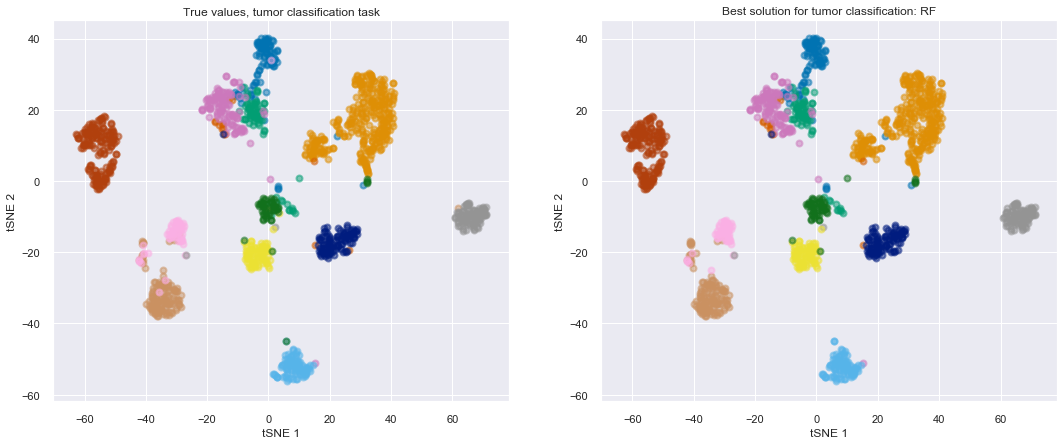

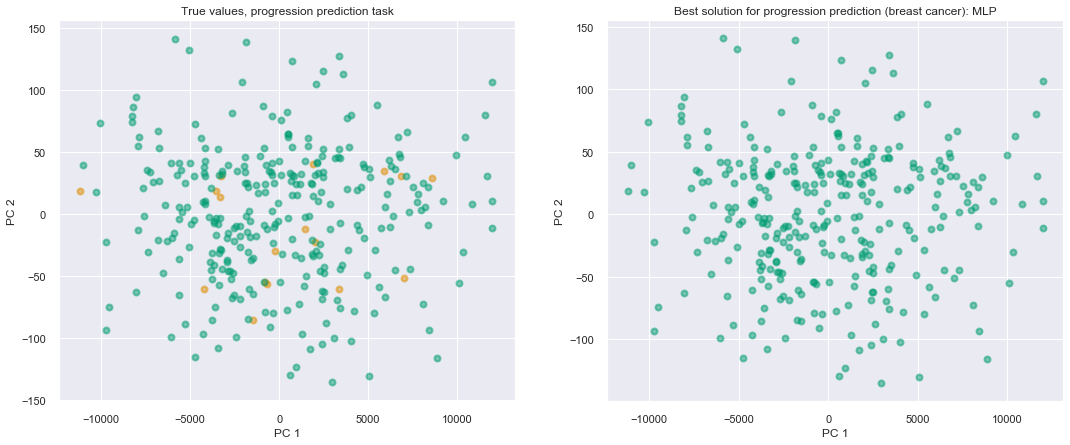

In [15]:
#best solution for tumor classification (logistic regression with L1+L2 penalty):

X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=test_size, random_state=42, stratify=y1)
clf = LogisticRegression(solver='saga', max_iter=400, penalty="elasticnet", l1_ratio=0.5, random_state=42).fit(X_train, y_train)
y_predicted=clf.predict(X_test)

X_embedded = TSNE(n_components=2,random_state=42).fit_transform(PCA(n_components=30).fit_transform(X_test))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
    
for color, target_name in zip(colors1, np.unique(y_test)):
    ax1.scatter(X_embedded[y_test == target_name, 0], X_embedded[y_test == target_name, 1],
                    color=color, lw=2, label=target_name, alpha=0.5)
ax1.set_title("True values, tumor classification task")
ax1.set_xlabel('tSNE 1')
ax1.set_ylabel('tSNE 2')

for color, target_name in zip(colors1, np.unique(y_test)):
    ax2.scatter(X_embedded[y_predicted == target_name, 0], X_embedded[y_predicted == target_name, 1],
                    color=color, lw=2, label=target_name, alpha=0.5)

ax2.set_title("Best solution for tumor classification: RF")
ax2.set_xlabel('tSNE 1')
ax2.set_ylabel('tSNE 2')

plt.show()

#best (and fastest) solution for progression prediction (with clinical): multi-layer perceptron (MLP):

X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=test_size, random_state=42, stratify=y2)
clf = MLPClassifier(random_state=42,solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2)).fit(X_train, y_train)
y_predicted=clf.predict(X_test)

X_embedded = PCA(n_components=2).fit_transform(X_test)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

for color, target_name in zip(colors2, np.unique(y_test)):
    ax1.scatter(X_embedded[y_test == target_name, 0], X_embedded[y_test == target_name, 1],
                    color=color, lw=2, label=target_name, alpha=0.5)
ax1.set_title("True values, progression prediction task")
ax1.set_xlabel('PC 1')
ax1.set_ylabel('PC 2')

for color, target_name in zip(colors2, np.unique(y_test)):
    ax2.scatter(X_embedded[y_predicted == target_name, 0], X_embedded[y_predicted == target_name, 1],
                    color=color, lw=2, label=target_name, alpha=0.5)
ax2.set_title("Best solution for progression prediction (breast cancer): MLP")
ax2.set_xlabel('PC 1')
ax2.set_ylabel('PC 2')

plt.show()


## Regression task

**Linear models (Ridge, Lasso, Elastic Net), RandomForest, AdaBoost, Gradient Tree Boosting (gradient boosting machine), multi-layer perceptron (MLP)**

**Create X and y for the regression task**:

In [7]:
X=df_noNA.drop(columns=['status', 'time','type'])
X=X[(df_noNA['type']=="BRCA")]

#replace string values by float in X
dictionary = {'Stage I': 1.5, 'Stage IA': 1.4, 'Stage IB': 1.6, 'Stage II': 2.5, 'Stage IIA': 2.4, 'Stage IIB': 2.6,
              'Stage III': 3.5, 'Stage IIIA': 3.4, 'Stage IIIB': 3.6, 'Stage IIIC': 3.8, 'Stage IV': 4.5}
X=X.replace({'stage': dictionary})
dictionary = {'MALE': 0, 'FEMALE': 1}
X=X.replace({'gender': dictionary})


dataset='TCGA.BRCA.sampleMap/RPPA_RBN'
samples=xena.dataset_samples(hub, dataset, None)

def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 

common_samples=intersection(X.index.values, samples)
prot_exp_list=xena.dataset_fetch(hub, dataset, common_samples, ["HER2","P53"]) 
X=X.loc[common_samples]

y1=prot_exp_list[0] #HER2 coded by ERBB2
y2=prot_exp_list[1] #P53 coded by TP53

from scipy.stats import pearsonr,spearmanr
print(spearmanr(y1,X["ERBB2"]))
print(spearmanr(y2,X["TP53"]))

print("Will use {} patient data points". format(len(y1)))

SpearmanrResult(correlation=0.6321357809165437, pvalue=4.8727135362352065e-73)
SpearmanrResult(correlation=0.2660545971757653, pvalue=7.017046739304839e-12)
Will use 643 patient data points


### Run regression task on train set and calculate prediction accuracy on the test set

In [8]:
#Linear models (Ridge, Lasso, Elastic Net), RandomForest, 
#AdaBoost, Gradient Tree Boosting (gradient boosting machine), multi-layer perceptron (MLP)

import time
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from scipy.stats import pearsonr,spearmanr

#will be splitting the dataset into train:test as 7:3
test_size=0.3

#def c_index3(y_pred, events, times):
    #from https://codereview.stackexchange.com/questions/202140/concordance-index-calculation
    
def printAndSaveInfoReg(name, my_time, y_test, y_predicted, 
                    reg_score, scoreDict, corrDict, rhoDict, timeDict):    
    timeDict[name]=my_time
    corr_coeff=pearsonr(y_test,y_predicted)[0]
    spearman=spearmanr(y_test,y_predicted)[0]
    scoreDict[name]=reg_score
    corrDict[name]=corr_coeff
    rhoDict[name]=spearman    
    print("---{}: {} seconds ---".format (name, my_time))
    print('{} accuracy scores: {} {} {}'.format(name, reg_score, corr_coeff, spearman))   


    
scores=[]
PearsonCorr=[]
SpearmanCorr=[]
times=[]

for X, y, title in [(X, y1, "Prediction of HER2 protein expression"), 
                            (X, y2, "Prediction of p53 protein expression")]:
    
    # Split the dataset in two for training and testing:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    scoreDict={}
    timeDict={}
    corrDict={}
    rhoDict={}
    
    #Ordinary Least Squares:
    start_time = time.time()
    reg = linear_model.LinearRegression().fit(X_train, y_train)
    printAndSaveInfoReg("Ordinary LS", time.time()-start_time, y_test, reg.predict(X_test), reg.score(X_test,y_test), scoreDict, corrDict, rhoDict, timeDict)

    #Lasso (L1 penalty on model coefficients), lambda(here alpha)==0.1
    start_time = time.time()
    reg = linear_model.Lasso(alpha=0.1).fit(X_train, y_train)
    printAndSaveInfoReg("Lasso 0.1", time.time()-start_time, y_test, reg.predict(X_test), 
                        reg.score(X_test,y_test),scoreDict, corrDict, rhoDict, timeDict)

    #Ridge (L2 penalty on model coefficients), lambda(here alpha)==0.5
    start_time = time.time()
    reg = linear_model.Ridge(alpha=.5).fit(X_train, y_train)
    printAndSaveInfoReg("Ridge 0.5", time.time()-start_time, y_test, reg.predict(X_test), 
                        reg.score(X_test,y_test),scoreDict, corrDict, rhoDict, timeDict)

    #Elastic Net (L1 and L2 penalty on model coefficients), chooses alpha and lambda using crossvalidation (5-fold)
    start_time = time.time()
    reg = linear_model.ElasticNetCV(cv=5, random_state=42).fit(X_train, y_train)
    printAndSaveInfoReg("Elastic Net CV", time.time()-start_time, y_test, reg.predict(X_test), 
                        reg.score(X_test,y_test),scoreDict, corrDict, rhoDict, timeDict)

    #RandomForest:
    start_time = time.time()
    reg = RandomForestRegressor(random_state=42).fit(X_train, y_train)
    printAndSaveInfoReg("RandomForest", time.time()-start_time, y_test, reg.predict(X_test), 
                        reg.score(X_test,y_test),scoreDict, corrDict, rhoDict, timeDict)

    #AdaBoost:
    start_time = time.time()
    reg = AdaBoostRegressor(random_state=42).fit(X_train, y_train)
    printAndSaveInfoReg("AdaBoostS", time.time()-start_time, y_test, reg.predict(X_test), 
                        reg.score(X_test,y_test),scoreDict, corrDict, rhoDict, timeDict)

    #Gradient Tree Boosting (gradient boosting machine):
    start_time = time.time()
    reg = GradientBoostingRegressor(random_state=42).fit(X_train, y_train)
    printAndSaveInfoReg("GBM", time.time()-start_time, y_test, reg.predict(X_test), 
                        reg.score(X_test,y_test),scoreDict, corrDict, rhoDict, timeDict)

    #multi-layer perceptron (MLP):
    start_time = time.time()
    reg = MLPRegressor(random_state=42, hidden_layer_sizes=(5, 2), learning_rate_init=0.01, early_stopping=True).fit(X_train, y_train)
    printAndSaveInfoReg("MLP", time.time()-start_time, y_test, reg.predict(X_test), 
                        reg.score(X_test,y_test),scoreDict, corrDict, rhoDict, timeDict)

    scores.append(scoreDict)
    times.append(timeDict)  
    PearsonCorr.append(corrDict)
    SpearmanCorr.append(rhoDict)

---Ordinary LS: 0.6928892135620117 seconds ---
Ordinary LS accuracy scores: 0.5016759349485784 0.7095692966589361 0.5518835799369691
---Lasso 0.1: 0.49550867080688477 seconds ---
Lasso 0.1 accuracy scores: 0.6572925579948491 0.8115039624986562 0.6541250467389562
---Ridge 0.5: 0.26276183128356934 seconds ---
Ridge 0.5 accuracy scores: 0.501677655485069 0.709569883903707 0.5518835799369691
---Elastic Net CV: 54.83412027359009 seconds ---
Elastic Net CV accuracy scores: 0.6554075844765068 0.8098970195554712 0.6413018802414401
---RandomForest: 373.12595415115356 seconds ---
RandomForest accuracy scores: 0.6954922803805276 0.835061615514191 0.6600475401955023
---AdaBoostS: 96.61784315109253 seconds ---
AdaBoostS accuracy scores: 0.6661693483777033 0.8172116969276055 0.6295482343221954
---GBM: 187.4268720149994 seconds ---
GBM accuracy scores: 0.662310122653993 0.8166148629141913 0.6326251268628813


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\s

---MLP: 14.652808666229248 seconds ---
MLP accuracy scores: -0.01585596677535639 nan nan
---Ordinary LS: 0.6665279865264893 seconds ---
Ordinary LS accuracy scores: 0.1519722060615899 0.42362164179185147 0.47433737041421425
---Lasso 0.1: 0.6121914386749268 seconds ---
Lasso 0.1 accuracy scores: 0.19998390192899881 0.4563595114577874 0.44592924216907837
---Ridge 0.5: 0.25084614753723145 seconds ---
Ridge 0.5 accuracy scores: 0.15198803913227565 0.42363208185700424 0.47433737041421425
---Elastic Net CV: 54.1107702255249 seconds ---
Elastic Net CV accuracy scores: 0.20923199925370806 0.46456624477167185 0.46345302689261075
---RandomForest: 418.71850967407227 seconds ---
RandomForest accuracy scores: 0.2808916964897983 0.5410933170284218 0.51147233677467
---AdaBoostS: 100.6624128818512 seconds ---
AdaBoostS accuracy scores: 0.2600161979986083 0.5268687550786714 0.4983071490115644
---GBM: 205.43386554718018 seconds ---
GBM accuracy scores: 0.2751876757807019 0.5254310948224352 0.48132985795

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal


**Choose the best model:**

                           Ordinary LS  Lasso 0.1  Ridge 0.5  Elastic Net CV  \
Prediction of HER2 amount     0.692889   0.495509   0.262762        54.83412   
Prediction of p53 amount      0.666528   0.612191   0.250846        54.11077   

                           RandomForest   AdaBoostS         GBM        MLP  
Prediction of HER2 amount    373.125954   96.617843  187.426872  14.652809  
Prediction of p53 amount     418.718510  100.662413  205.433866   1.730935  
                           Ordinary LS  Lasso 0.1  Ridge 0.5  Elastic Net CV  \
Prediction of HER2 amount     0.501676   0.657293   0.501678        0.655408   
Prediction of p53 amount      0.151972   0.199984   0.151988        0.209232   

                           RandomForest  AdaBoostS       GBM       MLP  
Prediction of HER2 amount      0.695492   0.666169  0.662310 -0.015856  
Prediction of p53 amount       0.280892   0.260016  0.275188 -0.000178  
                           Ordinary LS  Lasso 0.1  Ridge 0.5  Elasti

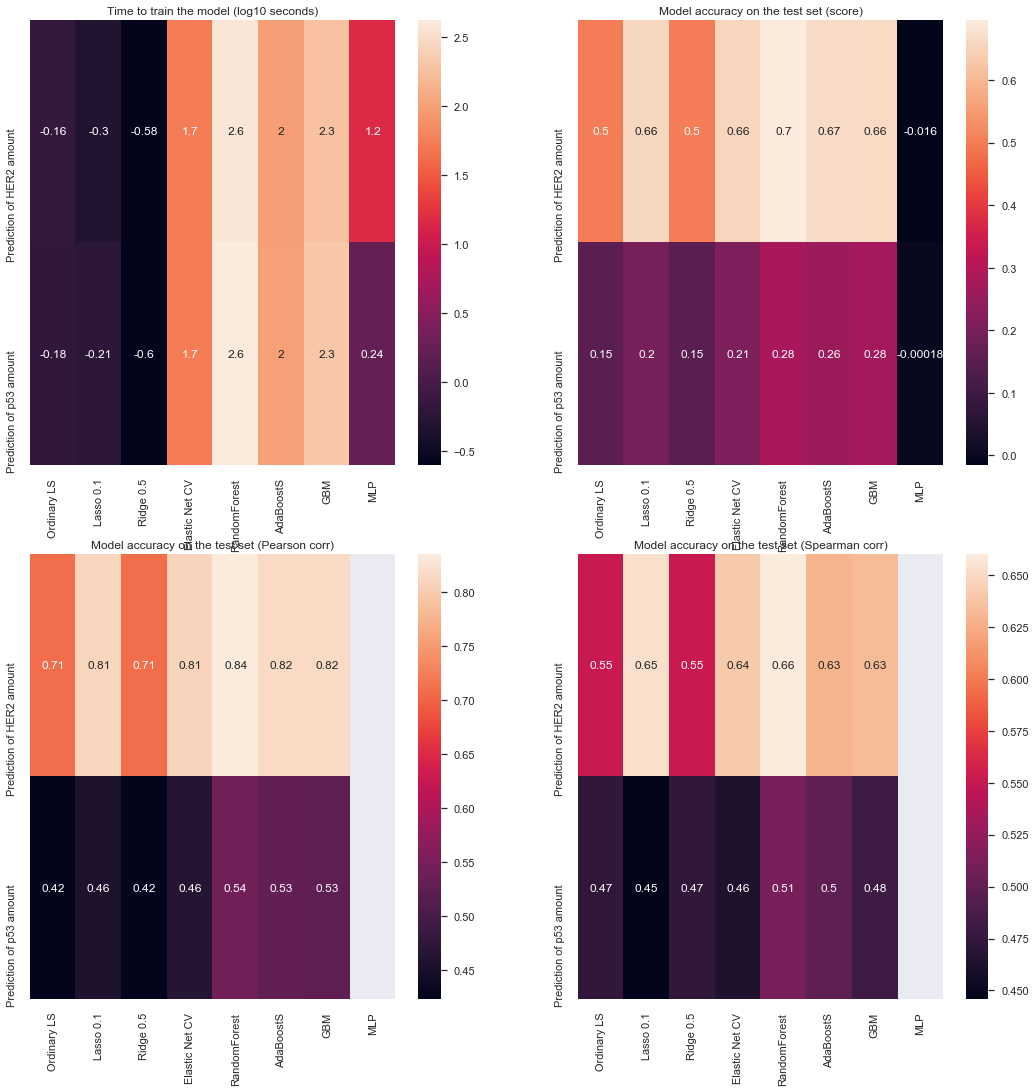

In [9]:
time_df=pd.DataFrame(times)
score_df=pd.DataFrame(scores)
pearson_df=pd.DataFrame(PearsonCorr)
spearman_df=pd.DataFrame(SpearmanCorr)

time_df.rename(index={0:'Prediction of HER2 amount',1:'Prediction of p53 amount'}, 
                 inplace=True)
score_df.rename(index={0:'Prediction of HER2 amount',1:'Prediction of p53 amount'}, 
                 inplace=True)
pearson_df.rename(index={0:'Prediction of HER2 amount',1:'Prediction of p53 amount'}, 
                 inplace=True)
spearman_df.rename(index={0:'Prediction of HER2 amount',1:'Prediction of p53 amount'}, 
                 inplace=True)

print(time_df)
print(score_df)
print(pearson_df)
print(spearman_df)

fig, axs = plt.subplots(2, 2)

fig.set_size_inches(18, 18)
    
sns.heatmap(np.log10(time_df), annot=True, ax=axs[0, 0])
axs[0, 0].set_title("Time to train the model (log10 seconds)")

sns.heatmap(score_df, annot=True, ax=axs[0, 1])
axs[0, 1].set_title("Model accuracy on the test set (score)")

sns.heatmap(pearson_df, annot=True, ax=axs[1, 0])
axs[1, 0].set_title("Model accuracy on the test set (Pearson corr)")

sns.heatmap(spearman_df, annot=True, ax=axs[1, 1])
axs[1, 1].set_title("Model accuracy on the test set (Spearman corr)")

plt.show()

**Visualize the best result**

SpearmanrResult(correlation=0.6600475401955023, pvalue=1.623150600114061e-25)
SpearmanrResult(correlation=0.51147233677467, pvalue=2.9344738877882315e-14)


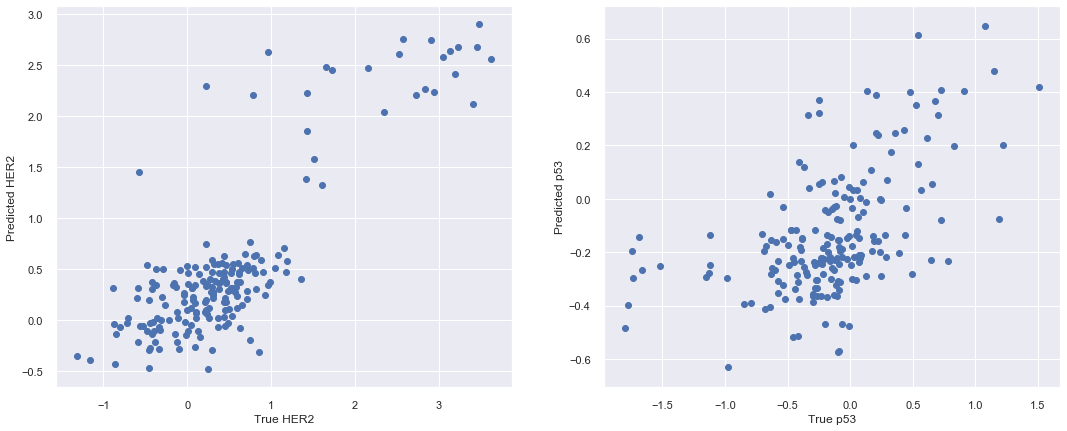

In [10]:
#RF:

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size=test_size, random_state=42)
regHer2 = RandomForestRegressor(random_state=42).fit(X_train, y_train)
print(spearmanr(y_test,regHer2.predict(X_test)))
ax1.scatter(y_test,regHer2.predict(X_test))
ax1.set_xlabel('True HER2')
ax1.set_ylabel('Predicted HER2')

X_train, X_test, y_train, y_test = train_test_split(X, y2, test_size=test_size, random_state=42)
regP53 = RandomForestRegressor(random_state=42).fit(X_train, y_train)
print(spearmanr(y_test,regP53.predict(X_test)))
ax2.scatter(y_test,regP53.predict(X_test))
ax2.set_xlabel('True p53')
ax2.set_ylabel('Predicted p53')

plt.show()

**Which features were the most important for the prediction?** 

Important features for prediction of HER2 protein expression:
ERBB2, importance: 0.49472
GRB7, importance: 0.08073
STARD3, importance: 0.06341
PGAP3, importance: 0.01229
MRPL45, importance: 0.00312
RUNDC1, importance: 0.00282
TXNRD3IT1, importance: 0.00273
BECN1, importance: 0.00259
GAD1, importance: 0.00219
WIPF2, importance: 0.00207
Important features for prediction of p53 protein expression:
TP53, importance: 0.05225
TCTN1, importance: 0.02624
SORBS1, importance: 0.02553
TCEAL1, importance: 0.02043
XKRX, importance: 0.01790
AGR3, importance: 0.01642
ESR1, importance: 0.01443
FSIP1, importance: 0.01078
IGJ, importance: 0.01051
TTC8, importance: 0.00888


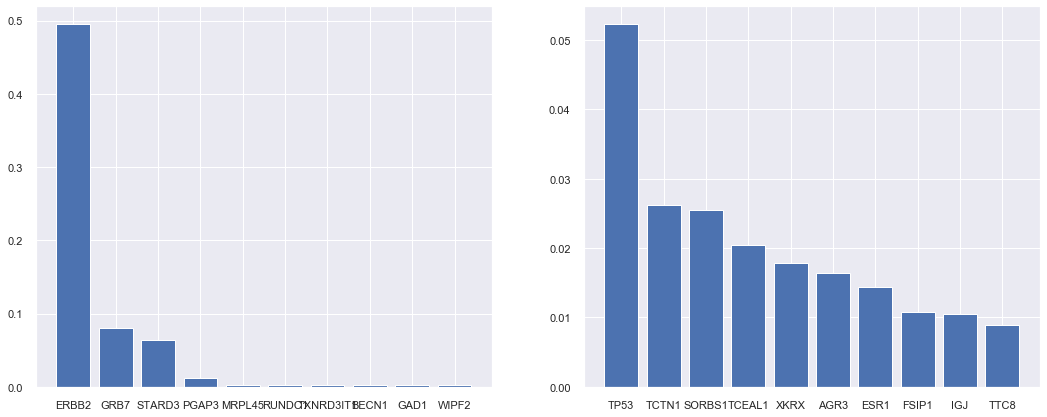

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

# get importance
importance = regHer2.feature_importances_

# summarize feature importance (top 10)
n=10
imp_scores = sorted(zip(importance, X.columns))
top = imp_scores[:-(n + 1):-1]
scores =[]
features=[]
print("Important features for prediction of HER2 protein expression:")
for v in top:
    print('%s, importance: %.5f' % (v[1],v[0])) 
    scores.append(v[0])
    features.append(v[1])
    
# plot feature importance
ax1.bar(height=scores,x=range(n))
plt.sca(ax1)
plt.xticks(range(n), features)

# get importance
importance = regP53.feature_importances_
# summarize feature importance (top 10)
n=10
imp_scores = sorted(zip(importance, X.columns))
top = imp_scores[:-(n + 1):-1]
scores =[]
features=[]
print("Important features for prediction of p53 protein expression:")
for v in top:
    print('%s, importance: %.5f' % (v[1],v[0])) 
    scores.append(v[0])
    features.append(v[1])
    
# plot feature importance
ax2.bar(height=scores,x=range(n))
plt.sca(ax2)
plt.xticks(range(n), features)

plt.show()